In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [2]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384328


In [3]:
# list_justificativa = random.sample(list_justificativa, 120000)

# print(list_justificativa[:10])

In [4]:
n_comp = 50

In [5]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [6]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [7]:
print(X_count.shape)

(384328, 154)


In [42]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2


# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

18 111


In [43]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [44]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.64 for 50 components


In [45]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [46]:
for k in range(min_k, max_k+1):
    print(f"Running kmeans for k={k}")
    # running kmeans
    model = BisectingKMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

    labels=model.labels_

    inertia = model.inertia_
    silhouette = metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)

    res_df.loc[len(res_df)] = {'k': k, 'inertia': inertia, 'silhouette': silhouette,
                            'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}

Running kmeans for k=18
Running kmeans for k=19
Running kmeans for k=20
Running kmeans for k=21
Running kmeans for k=22
Running kmeans for k=23
Running kmeans for k=24
Running kmeans for k=25
Running kmeans for k=26
Running kmeans for k=27
Running kmeans for k=28
Running kmeans for k=29
Running kmeans for k=30
Running kmeans for k=31
Running kmeans for k=32
Running kmeans for k=33
Running kmeans for k=34
Running kmeans for k=35
Running kmeans for k=36
Running kmeans for k=37
Running kmeans for k=38
Running kmeans for k=39
Running kmeans for k=40
Running kmeans for k=41
Running kmeans for k=42
Running kmeans for k=43
Running kmeans for k=44
Running kmeans for k=45
Running kmeans for k=46
Running kmeans for k=47
Running kmeans for k=48
Running kmeans for k=49
Running kmeans for k=50
Running kmeans for k=51
Running kmeans for k=52
Running kmeans for k=53
Running kmeans for k=54
Running kmeans for k=55
Running kmeans for k=56
Running kmeans for k=57
Running kmeans for k=58
Running kmeans f

## Elbow Method

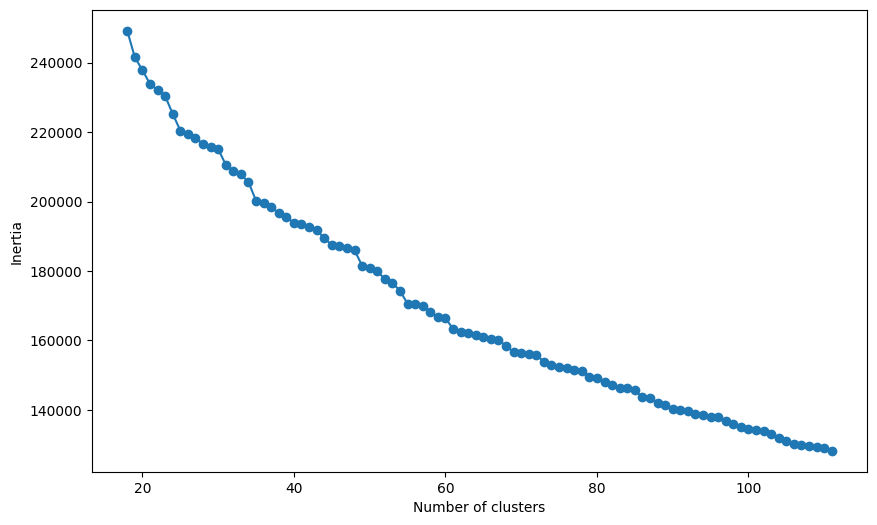

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()


## Silhouette Coefficient

In [48]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                       111.000000
inertia              128237.409808
silhouette                0.245889
calinski_harabasz      5879.816797
davies_bouldin            2.098448
Name: 93, dtype: float64


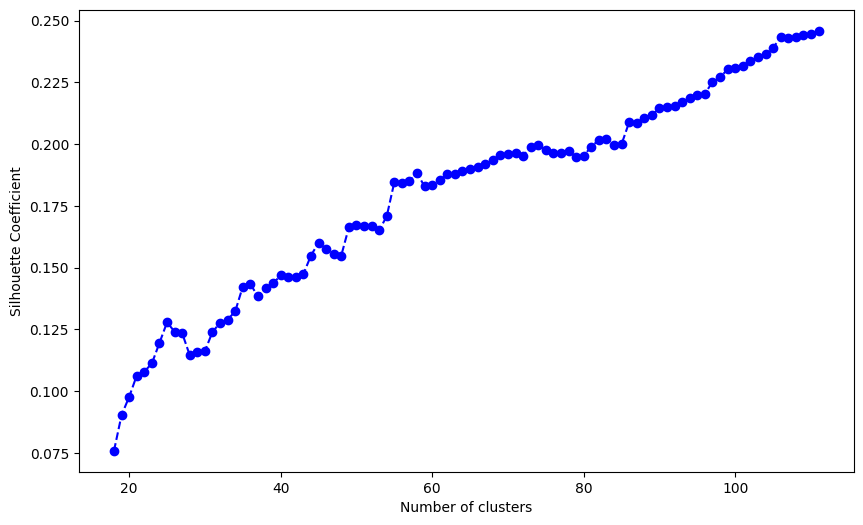

In [49]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [50]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                        19.000000
inertia              241527.165629
silhouette                0.090375
calinski_harabasz      9040.254489
davies_bouldin            2.911758
Name: 1, dtype: float64


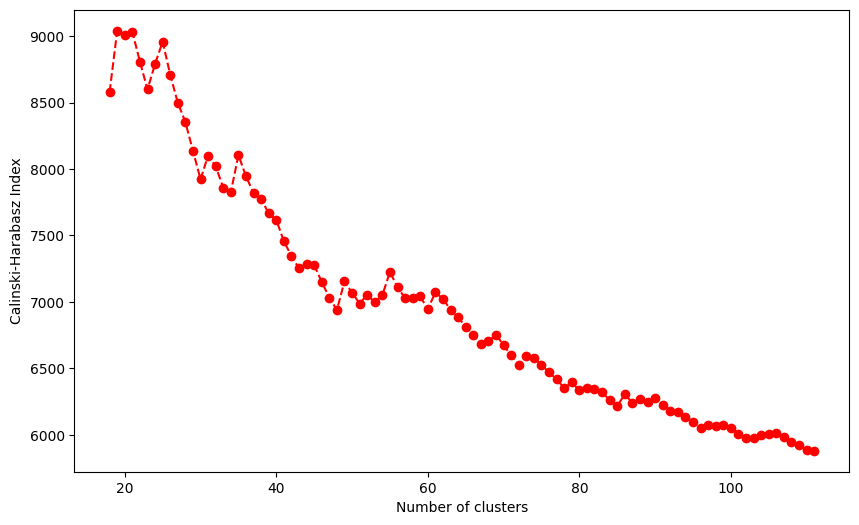

In [51]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [52]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                       106.000000
inertia              130136.686516
silhouette                0.243341
calinski_harabasz      6016.424327
davies_bouldin            2.083350
Name: 88, dtype: float64


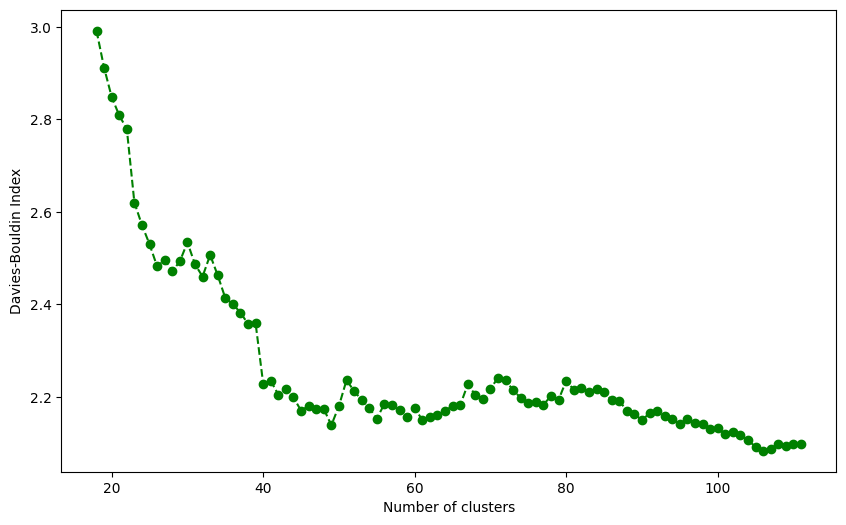

In [53]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [63]:
choosen_k = 106

In [64]:
model = BisectingKMeans(n_clusters=choosen_k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

labels=model.labels_
clusters=pd.DataFrame(list(zip(sample,labels)),columns=['phrase','cluster'])
clusters['cluster'].value_counts()

cluster
57     18223
74     10498
2      10337
39      8429
101     8096
       ...  
105      757
100      710
36       461
32       377
26       334
Name: count, Length: 106, dtype: int64

In [65]:
# quantize the clusters
clusters_count = clusters.groupby('cluster').count()
clusters_count = clusters_count.sort_values(by=['phrase'], ascending=False)

clusters_count.head(10)

,phrase
cluster,
57,18223
74,10498
2,10337
39,8429
101,8096
21,7879
89,7173
33,6958
92,6491


<Axes: xlabel='phrase'>

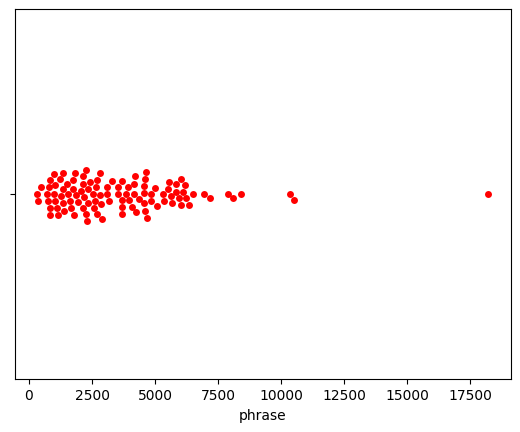

In [66]:
# 1-D swarmplot
sns.swarmplot(x=clusters_count['phrase'], color="red")

In [67]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

for i in range(choosen_k):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("------------------------------------------")

    for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 3979
 anexo
 conforme
 prazo
 autorizacao
 pcdp
 recursos
 devido
 dia
 deslocamento
 convocacao
------------------------------------------
  virtude mudanca data solenidade aniversario decea necessario alterar data solenidade aniversario gcc coincidindo conforme fc anexo
  face insercao anexo pcdp
  pcdp obedece prazo dias funcao carater prioritario confi gurado oficio dap dg alm ifnmg documento anexo
  atender prazo previsto antecedencia devido ajuste solicitado conforme mail anexo
  missao precursora interesse presidencia republica pr preparar atividade privada senhor presidente republica prevista dia jardim piranha rn conforme mail acionamento anexo
  servidor indicado participar evento conforme documento anexo
  servidora deslocamento dia conforme convocacao anexo adequacao encerramento exercicio
  considerando tratativas anteriores conforme documento anexo periodo deslocamento atualmente servidor exercicio remoto devido ocasiao efetiva mudanca contrato mo

In [68]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [69]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)

0.24334122584751322

## Calinski-Harabasz Index

In [70]:
metrics.calinski_harabasz_score(X, labels)

6016.424326627035

## Davies-Bouldin Index

In [71]:
metrics.davies_bouldin_score(X, labels)

2.0833497572557222